### 0. Import bibliotek

In [35]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ------ --------------------------------- 1.3/8.0 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 29.2 MB/s  0:00:00

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3 [scikit-learn]
   -------------------------- ------------- 2/3

In [1]:
import pandas as pd
import os
import tqdm
import matplotlib.pyplot as plt
import numpy as np

## 1. Praca na zbiorze

### 1.1 Zaciągnięcie danych

In [2]:
print(os.getcwd())

C:\Users\Michał J\Desktop\MJ_mgr\Codes


In [3]:
df = pd.read_csv('../Data/NPS_2025.csv', sep=';', keep_default_na=False, na_values=[''], low_memory=False) # ";" ze względu na kolumny opisowe gdzie wykorzysywano ","

In [4]:
df.head(1) #Surowy plik ma 99 kolumn, z czego dużo bezużytecznych

,Survey ID,Local Response Date,Booking ID,Customer ID,PNR,Delay (Flight 1),Delay (Flight 2),Delay Reason (Flight 1),Delay Reason (Flight 2),Booking channel,...,Space for hand luggage - F2,Temperature of the cabin - F2,Complementary accessories onboard - F2,Travel comfort comment - F2,Age of the Passenger,Purpose of trip,Purpose of Trip - Comment,Survey language,Passenger country of Residence,LOT travel frequency
0,16567668,15.12.2025 18:49,14222637,1230659547,XTD88W,0,NaN,NaN,NaN,LOT.COM,...,NaN,NaN,NaN,NaN,50 years old and more,Tourism,NaN,English,80.0,This was my first trip with LOT


In [5]:
len(df) #Surowy plik ma 88707 wierszy

88707

### 1.2 Pierwsze zmiany w danych

In [6]:
#Wyrzucam niepotrzebne kolumny z listy (konkretnie to te które uznałem za bezużyteczne)
df_ID = pd.read_csv('../Data/ID_Col.csv', sep=';')

wybrane_kolumny = df_ID[df_ID['Usability'] != 'bezużyteczna']['Name'].tolist()

# 2. Na wszelki wypadek sprawdzamy, czy te nazwy na pewno istnieją w Twoim df
# (To zapobiega błędowi KeyError)
istniejace_kolumny = [col for col in wybrane_kolumny if col in df.columns]

# 3. Zostawiamy w df tylko te kolumny
df = df[istniejace_kolumny]

# Liczba pozostałych kolumn
len(df.columns)

51

In [7]:
#Słownik mapowania nazw kolumn

col_names = {
    'Survey ID': 'ID',
    'Local Response Date': 'Response Date',
    'No. of Pax in Reservation': 'Pax on PNR',
    'LOT travel frequency': 'Airline Travel Frequency',
    'Age of the Passenger': 'Age',
    'NPS & OSAT comment': 'Comment',
    'Delay (Flight 1)': 'Delay - F1',
    'Delay (Flight 2)': 'Delay - F2',
    'Range (Flight 1)': 'Range - F1',
    'Range (Flight 2)': 'Range - F2',
    'Cabin Class (Flight 1)': 'Cabin Class - F1',
    'Cabin Class (Flight 2)': 'Cabin Class - F2',
    'Fligth 1 IFE Flag': 'IFE Flag - F1',
    'Flight 2 IFE Flag': 'IFE Flag - F2',
    'Check-in method (Declarative)': 'Check-in method',
    'Boarding at origin airport': 'Boarding',
    'Gate experience at origin airport': 'Gate experience',
    'Transfer between flights': 'Transfer',
    'In-flight entertainment - F1': 'IFE - F1',
    'In-flight entertainment - F2': 'IFE - F2'
}
# Zmiana nazw w głównym DataFrame
df = df.rename(columns=col_names)
# Zmiana wartości w kolumnie 'Name' w tabeli pomocniczej
df_ID['Name'] = df_ID['Name'].replace(col_names)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88707 entries, 0 to 88706
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   ID                                      88707 non-null  int64 
 1   Response Date                           88707 non-null  object
 2   Delay - F1                              87260 non-null  object
 3   Delay - F2                              35277 non-null  object
 4   Range - F1                              88707 non-null  object
 5   Range - F2                              37492 non-null  object
 6   Cabin Class - F1                        88707 non-null  object
 7   Cabin Class - F2                        37492 non-null  object
 8   M&M Flag                                88707 non-null  object
 9   Pax on PNR                              88707 non-null  object
 10  Country                                 88707 non-null  object
 11  Tr

### Obsługa braków, zmiana typów

In [37]:
#W zbiorze występują dwa typy braków danych: Nan oraz N/A, w zależności od zmiennej musimy inaczej je potraktować

# 1. Liczymy dosłowne teksty "N/A"
# (zadziała tylko jeśli wczytałeś dane z keep_default_na=False)
na_text_counts = (df == "N/A").sum()

# 2. Liczymy techniczne blanki (NaN / None)
blank_counts = df.isna().sum()

# 3. Łączymy to w jedną czytelną tabelę
missing_table = pd.DataFrame({
    'Tekstowe "N/A"': na_text_counts,
    'Techniczne Blanki': blank_counts
})
missing_table

,"Tekstowe ""N/A""",Techniczne Blanki
ID,0,0
Response Date,0,0
Delay - F1,0,0
Delay - F2,0,0
Range - F1,0,0
Range - F2,0,0
Cabin Class - F1,0,0
Cabin Class - F2,0,0
M&M Flag,0,0
Country,0,0


In [9]:
# Kolumna Delay - F1, jeżeli brak danych to znaczy że samolot się nie spóźnił
df['Delay - F1'] = df['Delay - F1'].fillna(0)

In [10]:
#Zamiana Transfer Flag na binarą
df['Transfer Flag'] = df['Transfer Flag'].map({'Yes': 1, 'No': 0})
print(df['Transfer Flag'].value_counts())

Transfer Flag
0    51215
1    37492
Name: count, dtype: int64


In [11]:
#Kolumna Delay -F2, jeżeli brak danych a Transfer Flag 1 to samolot się nie spóźnił - przypisz 0, w przeciwnym wypadku nie było 2 lotu i przypisz -999
df.loc[(df['Delay - F2'].isna()) & (df['Transfer Flag'] == 1), 'Delay - F2'] = 0
df.loc[(df['Delay - F2'].isna()) & (df['Transfer Flag'] == 0), 'Delay - F2'] = -999

In [12]:
#Kolumny Range - F2 i Cabin Class - F2, przypisujemy -999 kiedy transfer flag = 0
df.loc[(df['Range - F2'].isna()) & (df['Transfer Flag'] == 0), 'Range - F2'] = -999
df.loc[(df['Cabin Class - F2'].isna()) & (df['Transfer Flag'] == 0), 'Cabin Class - F2'] = -999

In [13]:
#Kolumna M&M Flag nie ma braków, ale zamieniam ją na binarną
df['M&M Flag'] = df['M&M Flag'].map({'Yes': 1, 'No': 0})
print(df['M&M Flag'].value_counts())

M&M Flag
0    74980
1    13727
Name: count, dtype: int64


In [14]:
# Flagujemy grupy większe równe 4 osób, nie jest to oficjalna grupa, ponieważ taka zaczyna się od 10 pasażerów, jednak w danych chciałem wyłapać
# Czy podróżowanie w więcej osób wpływa na satysfakcję
df['Group Flag'] = df['Pax on PNR'].isin(['4', '5+']).astype(int)
# Usuwamy starą kolumnę
df = df.drop(columns='Pax on PNR')
# Sprawdzamy nowe statystyki
print(df['Group Flag'].value_counts())

Group Flag
0    84176
1     4531
Name: count, dtype: int64


In [15]:
# Kolumna Comment ma kilka tekstowych "N/A", zmieniam to na NaN
df['Comment'] = df['Comment'].replace('N/A', np.nan)
# Ta kolumna nie będzie użyta w modelu, ale posłuży do analizy sentymentu

In [16]:
#Kolumna Check-in jest popsuta, NaN nie powinny wystąpić, narazie zostawiam bez zmian, docelowo zmieniam N/A na NaN

In [17]:
#Kolumny Boarding, Security check, Gate experience - zmieniam N/A na NaN
cols_to_fix = ['Boarding', 'Security check', 'Gate experience']
for col in cols_to_fix:
    
    df[col] = pd.to_numeric(df[col], errors='coerce') # zmienienie na float samo przekonwertuje N/A na NaN

In [18]:
#Agregacja kolumn dotyczących business lounge, zakładam że ci którzy nie wypełnili ankiety nie mieli okazji skorzystać z Lounge
lounge_cols = ['Business Lounge at WAW (Warsaw)', 'Business Lounge at ORD (Chicago)']
for col in lounge_cols:
    
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
# Pandas obsłuży to tak: [5, NaN] -> 5.0 | [4, 6] -> 5.0 | [NaN, NaN] -> NaN
df['Business Lounge'] = df[lounge_cols].mean(axis=1)

df = df.drop(columns=lounge_cols)

# Zastępujemy puste miejsca (NaN) wartością -999
df['Business Lounge'] = df['Business Lounge'].fillna(-999)

In [19]:
# Osoby, które nie miały transferu mają NaN, przypisuję im -999, natomiast osoby z N/A poprostu nie odpowiedziały
df.loc[(df['Transfer'].isna()) & (df['Transfer Flag'] == 0), 'Transfer'] = -999
# W następnej kolejności zmieniam N/A na nan i konwertuje na float
df['Transfer'] = pd.to_numeric(df['Transfer'], errors='coerce')

In [20]:
#Zmienna Baggage Claim - bardzo dużo braków, ze względu na to że wielu pasażerów nie nadaje bagażu, przypisuje wiec -999
df['Baggage claim'] = pd.to_numeric(df['Baggage claim'], errors='coerce')
df.loc[df['Baggage claim'].isna(), 'Baggage claim'] = -999

In [21]:
#Zamiana IFE Flags na binarną
df['IFE Flag - F1'] = df['IFE Flag - F1'].map({'Yes': 1, 'No': 0})
print(df['IFE Flag - F1'].value_counts())
df['IFE Flag - F2'] = df['IFE Flag - F2'].map({'Yes': 1, 'No': 0})
print(df['IFE Flag - F2'].value_counts())

IFE Flag - F1
0    77150
1    11557
Name: count, dtype: int64
IFE Flag - F2
0    83307
1     5400
Name: count, dtype: int64


In [22]:
# Zmienne dotyczące IFE, jeżeli pax nie miał dostępu (flaga 0) to przypisz -999
df.loc[df['IFE Flag - F1'] == 0, 'IFE - F1'] = -999
df['IFE - F1'] = pd.to_numeric(df['IFE - F1'], errors='coerce')
df.loc[df['IFE Flag - F2'] == 0, 'IFE - F2'] = -999
df['IFE - F2'] = pd.to_numeric(df['IFE - F2'], errors='coerce')

In [23]:
print(df['Complementary accessories onboard - F1'].value_counts())

Complementary accessories onboard - F1
5      1907
4       605
3       199
N/A      54
2        50
1        39
Name: count, dtype: int64


In [24]:
#Zajmujemy siękolumną dotyczącą akcesoriów, mamy bardzo dużo braków, wynika to głównie z faktu że tylko Premium i Biznes dostają te rzeczy
import pandas as pd
import numpy as np

analysis_df = df.copy()

# pomocnicze kolumny logizzne
analysis_df['Is_Blank'] = analysis_df['Complementary accessories onboard - F1'].isna()
analysis_df['Is_NA_Text'] = analysis_df['Complementary accessories onboard - F1'] == 'N/A'
analysis_df['Has_Rating'] = pd.to_numeric(analysis_df['Complementary accessories onboard - F1'], errors='coerce').notna()

# Tabelka z missingami
missing_report = analysis_df.groupby('Cabin Class - F1').agg({
    'Is_Blank': 'sum',      # Suma fizycznych pustych pól
    'Is_NA_Text': 'sum',    # Suma wpisów tekstowych "N/A"
    'Has_Rating': 'sum'     # Ile osób wystawiło ocenę
})

# % Udział ocen
missing_report['Completeness_%'] = (missing_report['Has_Rating'] / 
                                    (missing_report['Is_Blank'] + missing_report['Is_NA_Text'] + missing_report['Has_Rating']) * 100).round(2)

print(missing_report)
#podsumowując potwierdziło się że economy tego nie dostaje, więc przypisuję im -999, premium ma wysoki poziom 

                  Is_Blank  Is_NA_Text  Has_Rating  Completeness_%
Cabin Class - F1                                                  
C                     3152          22        1266           28.51
P                      100          32        1534           92.08
Y                    82601           0           0            0.00


In [25]:
# Sprawdzamy hipotezę: Akcesoria = Klasa (C/P) + Zasięg (LH)
range_check = df.groupby(['Cabin Class - F1', 'Range - F1']).agg({
    'Complementary accessories onboard - F1': lambda x: pd.to_numeric(x, errors='coerce').notna().mean() * 100
}).round(2)

range_check.columns = ['% wypełnionych ocen']
print("Procent wystawionych ocen w zależności od klasy i zasięgu:")
print(range_check)
#To pokazuje nam że akcesoria dostaje się jedynie na LH nie w economy

Procent wystawionych ocen w zależności od klasy i zasięgu:
                             % wypełnionych ocen
Cabin Class - F1 Range - F1                     
C                DOM                        0.00
                 LH                        97.53
                 SH                         0.00
P                LH                        97.40
                 SH                         0.00
Y                DOM                        0.00
                 LH                         0.00
                 SH                         0.00


In [26]:
# Lista par kolumn do przetworzenia (zmienna oceny oraz jej warunki)
flights = [
    {'score': 'Complementary accessories onboard - F1', 'class': 'Cabin Class - F1', 'range': 'Range - F1'},
    {'score': 'Complementary accessories onboard - F2', 'class': 'Cabin Class - F2', 'range': 'Range - F2'}
]

for f in flights:

    df[f['score']] = pd.to_numeric(df[f['score']], errors='coerce')
    
    # Definicja braku usługi:
    # - Klasa ekonomiczna (Y) 
    # - LUB lot inny niż długodystansowy (nie LH)
    # - LUB (tylko dla F2) brak drugiego lotu (jeśli stosujesz tam np. NaN dla nietransferowych)
    mask_no_service = (df[f['range']] != 'LH') | (df[f['class']] == 'Y')
# Przypisuje pasażerom ktorzy nie mieli stycznosci -999
    df.loc[mask_no_service, f['score']] = -999

In [27]:
#Pozbywamy się N/A dla kolumn F1 i przekszatałcamy na numeric
cols_f1 = [col for col in df.columns if 'F1' in col]
#tych nie chce zmieniać
exceptions = ['Delay - F1', 'Range - F1', 'IFE Flag - F1','Cabin Class - F1']

cols_to_convert = [col for col in cols_f1 if col not in exceptions]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [28]:
#Dla F2 bedzie podobnie, jednak najpierw trzeba oznaczyć te rekordy które mają Transfer Flag 0 przypisując -999
cols_f2 = [col for col in df.columns if 'F2' in col]

exceptions_f2 = ['Delay - F2', 'Range - F2', 'IFE Flag - F2','Cabin Class - F2']

cols_to_convert_f2 = [col for col in cols_f2 if col not in exceptions_f2]

#  paxbez transferu (Flag 0) otrzymują -999
for col in cols_to_convert_f2:
    df.loc[df['Transfer Flag'] == 0, col] = -999

# konwersja na numeric
for col in cols_to_convert_f2:
    df[col] = pd.to_numeric(df[col], errors='coerce')



Rozkład wartości dla Punctuality - F2 w zależności od Transfer Flag:
Transfer Flag  Punctuality - F2
0              -999.0              51215
1               5.0                22262
                4.0                 7846
                3.0                 3080
                1.0                 2001
                2.0                 1441
                NaN                  862
Name: count, dtype: int64


In [30]:
#Jeżeli mamy blank w wieku to oznaczam jako nie chcę podawać
df.loc[df['Age'].isna(), 'Age'] = "I prefer not to say" 

In [36]:
#Korzystamz  MICe do Impyutacji (DRAFT!)
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 1. Wybieramy tylko kolumny numeryczne, które mają NaN (ale pomijamy te z -999)
# Algorytm zignoruje -999 i potraktuje to jako normalną wartość, co jest OK!
cols_to_impute = df.select_dtypes(include=['number']).columns

# 2. Inicjalizujemy Imputer
# random_state zapewnia, że za każdym razem dostaniesz ten sam wynik
ii = IterativeImputer(max_iter=10, random_state=42)

# 3. Wykonujemy imputację
df[cols_to_impute] = ii.fit_transform(df[cols_to_impute])

# 4. Zaokrąglamy wyniki do liczb całkowitych (opcjonalnie, skoro to skala 1-5)
df[cols_to_impute] = df[cols_to_impute].round()

print("Imputacja zakończona sukcesem dla wszystkich kolumn.")

Imputacja zakończona sukcesem dla wszystkich kolumn.


In [ ]:
# Dla Airline Travel Frequency inna metoda, poniewaz jest kategorialna

### 1.2 Poboczne statystyki i wizualizacje

In [28]:
#Sprawdzam z jakiego czasu mamy dane ankietowe
df['Response Date'] = df['Response Date'].str[:10]
df['Response Date'] = pd.to_datetime(df['Response Date'], format='%d.%m.%Y')
print(df['Response Date'].head())

0   2025-12-15
1   2025-12-15
2   2025-12-16
3   2025-12-15
4   2025-12-15
Name: Response Date, dtype: datetime64[ns]


In [29]:
df['Response Date'].min() #Pierwsza ankieta wpadła 3 styzcnia 2025

Timestamp('2025-01-03 00:00:00')

In [30]:
df['Response Date'].max() #Ostatnia ankieta wpadła 16 grudnia 2025

Timestamp('2025-12-16 00:00:00')

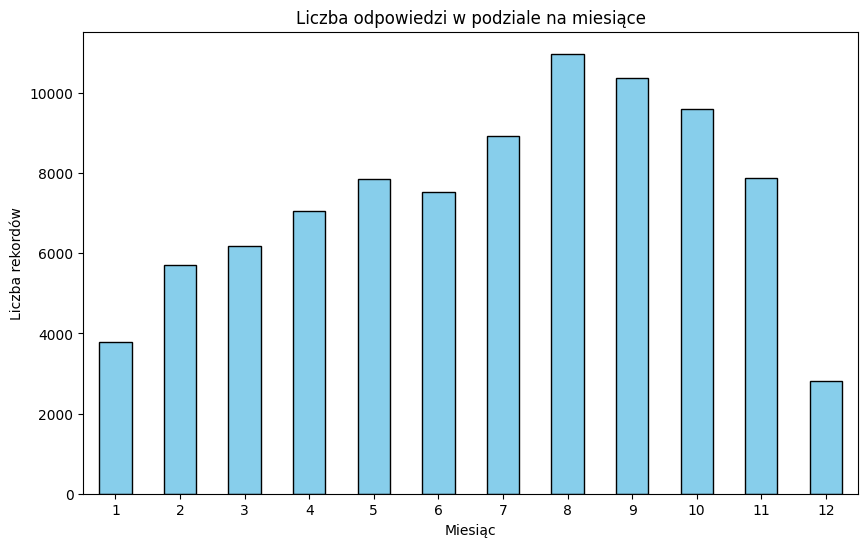

In [31]:
# Wyciągamy miesiąc i liczymy wystąpienia
monthly_data = df['Response Date'].dt.month.value_counts().sort_index()

# Wykres
plt.figure(figsize=(10, 6))
monthly_data.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Liczba odpowiedzi w podziale na miesiące')
plt.xlabel('Miesiąc')
plt.ylabel('Liczba rekordów')
plt.xticks(rotation=0)
plt.show()
#Zauważalnie w grudniu odpowiedzi było najmniej, to oczywiste ponieważ ostatnia ankieta wpadła 16 grudnia 2025

In [32]:
#Sprawdzam jakie mam unikalne kategorie wieku
df['Age'].unique()

array(['50 years old and more', '40-49', '30-39', 'Under 30 years old',
       nan, 'I prefer not to say'], dtype=object)

In [34]:
df.loc[df['Age'].isna(), 'Age'] = "I prefer not to say" #Braki w zmiennej age wynikają z niechęci do zaznaczenia

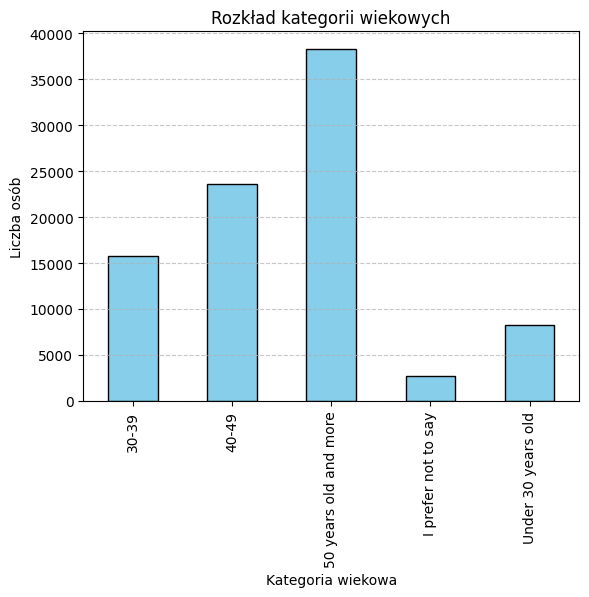

In [35]:
df['Age'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Rozkład kategorii wiekowych')
plt.xlabel('Kategoria wiekowa')
plt.ylabel('Liczba osób')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Dodaje pomocnicze linie poziome

plt.show()

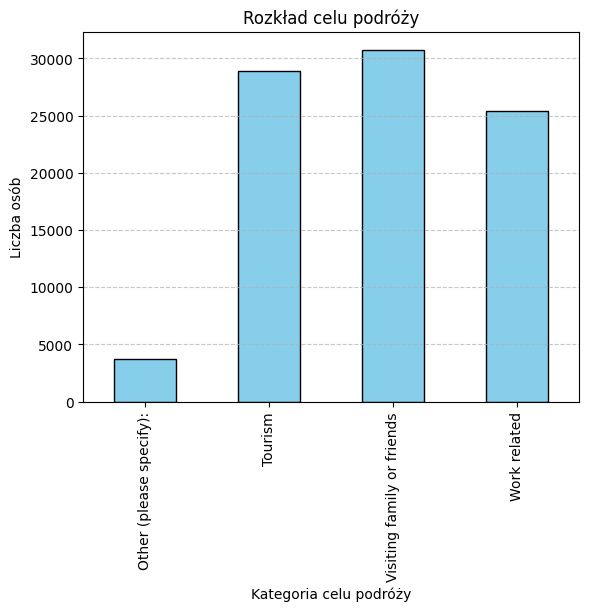

In [16]:
df['Purpose of trip'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Rozkład celu podróży')
plt.xlabel('Kategoria celu podróży')
plt.ylabel('Liczba osób')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Dodaje pomocnicze linie poziome

plt.show()

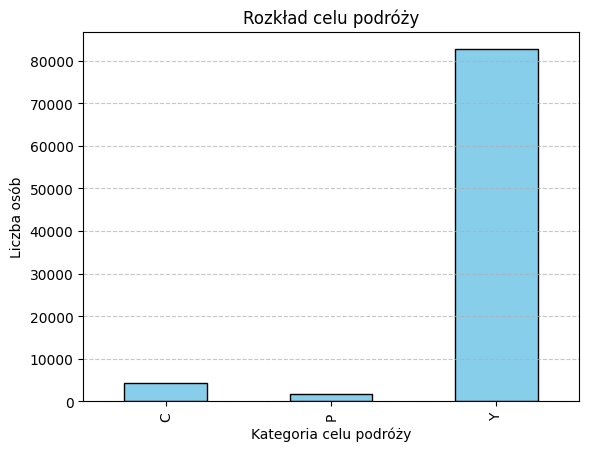

In [17]:
df['Cabin Class - F1'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Rozkład klas serwisowych')
plt.xlabel('Klasa serwisowa')
plt.ylabel('Liczba osób')
plt.grid(axis='y', linestyle='--', alpha=0.7) # Dodaje pomocnicze linie poziome

plt.show()
#Najmniej jest premium, ponieważ ta klasa nie występuje u tego przewoźnika na trasach Short Haul

### 1.4 Modyfikacja zmiennych

In [ ]:
# Tworzymy zmienną binarną
# NPS <= 8 -> 1 (Niezadowolony)
# NPS > 8  -> 0 (Zadowolony)
df['NPS_bin'] = (df['NPS'] <= 8).astype(int)

# Szybkie sprawdzenie rozkładu
print(df['NPS_bin'].value_counts())